__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики.

# Обзор средств ускорения программ на Python

In [1]:
# стандартные импорты
import numpy as np
import math as m
import matplotlib.pyplot as plt
import time
import timeit
%matplotlib inline

figsizeConst = (11.6, 7.)
plt.rc('font', size=20)
plt.rc('lines', linewidth=4, linestyle='-', marker='o', markersize=12)

## Средства ускорения
* cython
* scipy.weave
* SWIG
* ...
* __векторизация из Numpy__
* __Numba__

## Cython: 0.5 * C + 0.5 * Python
Пример кода (c), численное интегрирование:

In [ ]:
# cython не установлен --- код нерабочий
'''
cdef extern from "math.h":
    double sin(double x)

cdef double f(double x):
    return sin(x**2)

cpdef double integrate_f(double a, double b, int N):
    cdef double dx, s
    cdef int i

    dx = (b-a)/N
    s = 0
    for i in range(N):
        s += f(a+i*dx)
    return s * dx
'''

## Векторизация

Еще раз про "быстрые массивы" из __Numpy__:

* элементы массива должны быть одного типа
* неизменяемость длины массива
* поддержка векторизованных операций

### Принцип векторизованных операций: 
* задействование скомпилированных с языка C циклов, реализованных внутри библиотеки Numpy
* 1 вместо n инструкций для интерпретации в случае обработки цикла

In [2]:
def CalculateFibonacciNumber(n):
    a = 0
    b = 1
    for i in range(n):
        a, b = b, a + b
        
    return a

In [3]:
CalculateFibonacciNumber(5)

5

$$ 
    t_{scalar} = (t_{interpret} + t_{execut1}) \cdot n \\
    t_{vectorized} = t_{interpret} + t_{execut2} n \\
    t_{execut1} \text{- время исполнения инструкции, переведенной в машинный код интерпретатором} \\
    t_{execut2} \text{- время исполнения инструкции, переведенной в машинный код компилятором языка С} \\
$$


Массив $\mathbf{v} = \left( v_0, v_1, ..., v_{n-1} \right)$ 

* векторизованная функция: $\mathbf{f}(\mathbf{v}) = \left( f(v_0), f(v_1), ..., f(v_{n-1}) \right)$
* векторизованная арифметическая операция: $\mathbf{u} \circ \mathbf{v} = \left( u_0 \circ v_0 , u_1 \circ v_1, ..., u_{n-1} \circ v_{n-1} \right)$

Реализации покоординатных операций над массивами в явном виде:

In [4]:
def AddArrays(array1, array2):
    n = len(array1)
    resultArray = [0. for i in range(n)]
    for i in range(n):
        resultArray[i] = array1[i] + array2[i]
    return resultArray

def MultiplyArrays(array1, array2):
    n = len(array1)
    resultArray = [0. for i in range(n)]
    for i in range(n):
        resultArray[i] = array1[i] * array2[i]
    return resultArray

def SpecificFunctionArray(array):
    n = len(array)
    resultArray = [0. for i in range(n)]
    for i in range(n):
        resultArray[i] = m.cos(m.sin(array[i]**2.)) / (1. + m.exp(-2.*array[i]))
    return resultArray

In [5]:
n = int(1e3)
arrayA = [5*i for i in range(n)]
arrayB = arrayA.copy()

print('Результаты:\n')
print (AddArrays(arrayA, arrayB)[1:10], '\n')
print (MultiplyArrays(arrayA, arrayB)[1:10], '\n')
print (SpecificFunctionArray(arrayB)[1:10], '\n')

Результаты:

[10, 20, 30, 40, 50, 60, 70, 80, 90] 

[25, 100, 225, 400, 625, 900, 1225, 1600, 2025] 

[0.9912092840277956, 0.8745129494099381, 0.5977579234961761, 0.6592921701839249, 0.9845490890471026, 0.5421494815752034, 0.9760419149072135, 0.6958275759456342, 0.5648938778113741] 



In [6]:
# для графика времени выполнения
lengthsList = [int(1.5**i) for i in range(2, 10)]
runtimesList = []

for length in lengthsList:
    arrayA = [5*i for i in range(int(length))]
    
    timing = %timeit -o SpecificFunctionArray(arrayA)
    runtimesList.append(timing.best)

2.54 µs ± 70.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.23 µs ± 47.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.96 µs ± 69.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.44 µs ± 96.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.1 µs ± 465 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.3 µs ± 885 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
21.1 µs ± 963 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
33 µs ± 3.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


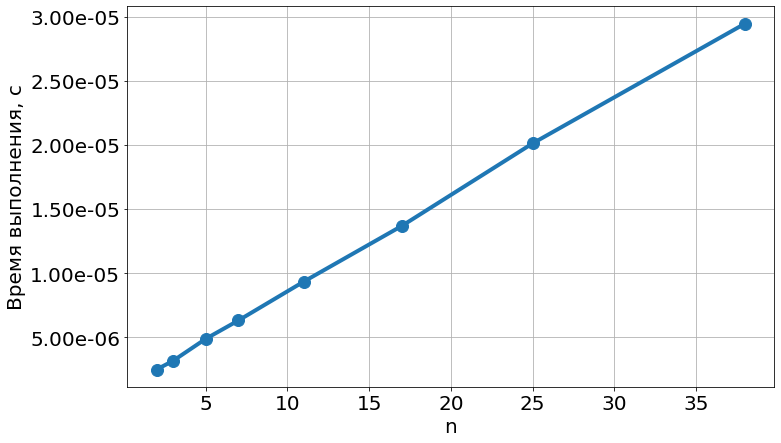

In [7]:
# график времени выполнения
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=figsizeConst)
plt.plot(lengthsList, runtimesList)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel('Время выполнения, с')
plt.xlabel('n')
plt.grid('off')
plt.show()

In [8]:
# то же самое, с использованием векторизации
n = int(1e3)
arrayA = np.array([5*i for i in range(n)])
arrayB = arrayA.copy()

print('Результат:\n')
print (arrayA[1:10], '\n')
print ((arrayA[:] + arrayB[:])[1:10], '\n')
print ((arrayA[:]*arrayB[:])[1:10], '\n')
print ((np.cos(np.sin(arrayB[:]**2.)) / (1. + np.exp(-2.*arrayB[:])))[1:10], '\n')

Результат:

[ 5 10 15 20 25 30 35 40 45] 

[10 20 30 40 50 60 70 80 90] 

[  25  100  225  400  625  900 1225 1600 2025] 

[0.99120928 0.87451295 0.59775792 0.65929217 0.98454909 0.54214948
 0.97604191 0.69582758 0.56489388] 



In [11]:
# для графика времени выполнения
lengthsList = [int(1.5**i) for i in range(2, 20)]
runtimesList = []

for length in lengthsList:
    arrayA = np.array([5*i for i in range(int(length))])
    
    timing = %timeit -o np.cos(np.sin(arrayA[:]**2.)) / (1. + np.exp(-2.*arrayA[:]))
    runtimesList.append(timing.best)

12.3 µs ± 2.37 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
11.5 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.3 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.5 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
12.3 µs ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.5 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
12.6 µs ± 622 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
16.5 µs ± 3.63 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


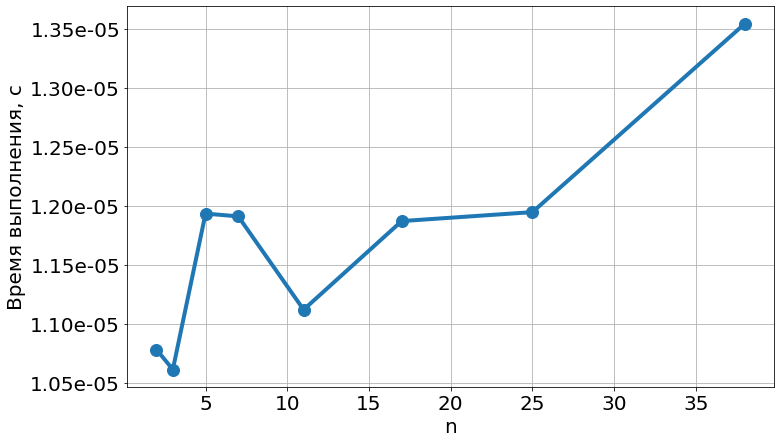

In [12]:
# график времени выполнения
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=figsizeConst)
plt.plot(lengthsList, runtimesList)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel('Время выполнения, с')
plt.xlabel('n')
plt.grid('off')
plt.show()

In [13]:
def SpecificFunctionArrayVectorized(array):
    return np.cos(np.sin(array[:]**2.)) / (1. + np.exp(-2.*array[:]))

In [29]:
# для графика ускорений
lengthsList = [int(1.5**i) for i in range(2, 20)]
runtimesScalarList, runtimesVectorizedList = [], []


for length in lengthsList:
    arrayA = np.array([5*i for i in range(int(length))])
    arrayB = np.array(arrayA)
    
    timing1 = %timeit -o SpecificFunctionArray(arrayB)
    timing2 = %timeit -o SpecificFunctionArrayVectorized(arrayB)
    
    runtimesScalarList.append(timing1.best)
    runtimesVectorizedList.append(timing2.best)
                                                                   

runtimesScalarList = np.array(runtimesScalarList) 
runtimesVectorizedList = np.array(runtimesVectorizedList)

20 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.2 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
28.2 µs ± 446 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
12.4 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
50.8 µs ± 6.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.3 µs ± 290 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
68 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.4 µs ± 148 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
107 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.5 µs ± 337 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
150 µs ± 5.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.5 µs ± 44.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
220 µs ± 8.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
12.4 µs ± 609 ns per loop (mean ± std. dev. of 

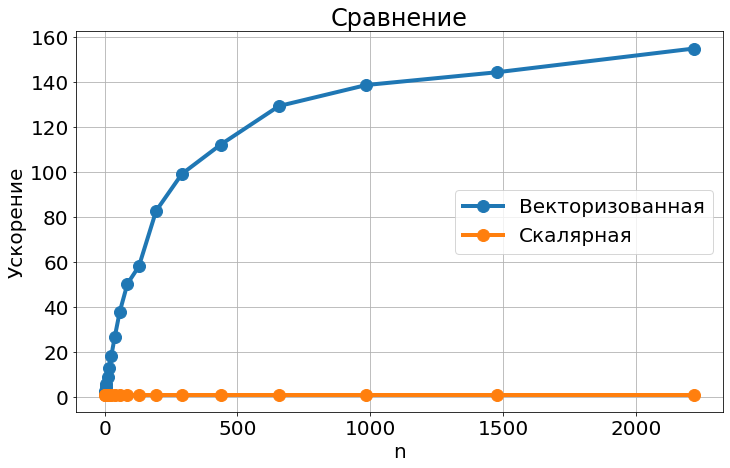

In [30]:
# графики ускорений
plt.figure(figsize=figsizeConst)
plt.title('Сравнение')
plt.plot(lengthsList[:], runtimesScalarList[:]/runtimesVectorizedList[:], label='Векторизованная')
plt.plot(lengthsList[:], runtimesScalarList[:]/runtimesScalarList[:], label='Скалярная')
plt.ylabel('Ускорение')
plt.xlabel('n')
plt.legend(loc='best')
plt.grid('off')
plt.show()

### Однородное линейное уравнение теплопроводности

Шаг #10000
Шаг #20000
Шаг #30000
Шаг #40000
Шаг #50000
Шаг #60000
Шаг #70000
Шаг #80000
Вычисления заняли 1.17e+00 с


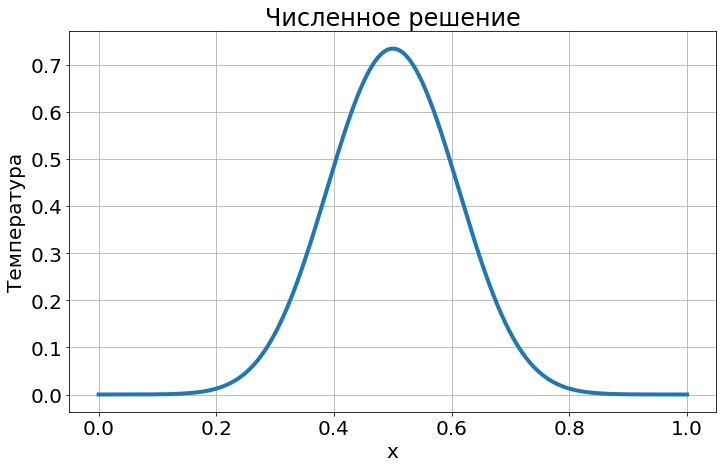

In [21]:
xLeft = 0.
xRight = 1.
kappa = 0.1
t = 0.
tEnd = 0.04

def InitialCondition(x):
    if x < 0.6 and x > 0.4:
        return 1.
    else:
        return 0.


def SetInitialCondition(function, array, numPoints, h):
    for i in range(numPoints):
        array[i] = function(i * h)

def MakeStepScalar(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h)
    
    # явная реализация покоординатных операций с помощью цикла
    for i in range(1, numPoints - 1):
        uNew[i] = uOld[i] + courant * (uOld[i + 1] - 2 * uOld[i] + uOld[i - 1])
    
    
def MakeStepVectorized(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h) 
    
    # неявная реализация поокоординатных операций с помощью векторизации
    uNew[1:numPoints-1] = uOld[1:numPoints-1] + courant*(uOld[2:numPoints] - 2*uOld[1:numPoints-1]\
                                                        + uOld[:numPoints-2])



# main
counter = 0
counterBlocks = 0
numBlocks = int(1e3)
numPoints = int(numBlocks + 1)
uOld, uNew = np.zeros(numPoints), np.zeros(numPoints)
h = float(xRight - xLeft) / float(numBlocks)
dt = h**2 / (kappa * 20.)

                
start = timeit.default_timer()
SetInitialCondition(InitialCondition, uOld, numPoints, h)
while t < tEnd:
    
    # закомментироапть одну версию функции - раскомментировать другую
    #MakeStepScalar(uOld, numPoints, h, dt, kappa, uNew)
    MakeStepVectorized(uOld, numPoints, h, dt, kappa, uNew)
    
    uOld = uNew
    t += dt; counter += 1
    if (counter % int(1e4)) == 0:
        print ('Шаг #%d' % counter)


end = timeit.default_timer()
runtime = end - start
print ('Вычисления заняли %.2e с' % runtime)
    
    
xArray = np.linspace(xLeft, xRight, numPoints)
plt.figure(figsize=figsizeConst)
plt.title('Численное решение')
plt.plot(xArray, uNew, '-')
plt.xlabel('x')
plt.ylabel('Температура')
plt.grid('off')
plt.show()

### Метод Якоби решения СЛАУ
СЛАУ возникает в результате использования разностного шаблона "крест" при дискретизации уравнения Лапласа в квадратной области с граничными условиями типа Дирихле:

In [22]:
numBlocksX = 100
numBlocksY = 100

length = 5.
height = 5.

xArray = np.linspace(0., length, numBlocksX)
yArray = np.linspace(0., height, numBlocksY)

hx = length / (numBlocksX - 1)
hy = height / (numBlocksY - 1)

p0 = np.zeros((numBlocksY, numBlocksX))

# граничные условия: выбраны для получения красивого графика
p0[-1,:] = np.sin(1.5 * np.pi * xArray/xArray[-1]) # сверху
p0[:,-1] = np.cos(1.5 * np.pi * yArray/yArray[-1]) # справа

In [23]:
def SolveLaplace2D_JacobiScalar(p, numBlocksX, numBlocksY,  tolerance): 
    normL2 = 1.
    pn = np.zeros((numBlocksY, numBlocksX))
    iterations = 0
    
    start = timeit.default_timer()
    
    while normL2 > tolerance:
        for i in range(numBlocksX):
            for j in range(numBlocksY):
                pn[i, j] = p[i, j]
        
        # итерации
        for i in range(1, numBlocksX - 1):
            for j in range(1, numBlocksY - 1):
                p[i, j] = 0.25 * (pn[i, j + 1] + pn[i, j - 1] +\
                                      pn[i + 1, j] + pn[i - 1, j])
        
        numerator, denumenator = 0., 0.
        for i in range(numBlocksX):
            for j in range(numBlocksY): 
                numerator += (p[i, j] - pn[i, j])**2
                denumenator += pn[i, j]**2
            
        normL2 = m.sqrt(numerator/denumenator)
        iterations += 1
    
    runtime = timeit.default_timer() - start
    print('%d итераций завершены в процессе работы скалярной реализации метода Якоби; вычисления заняли %.2f с' % (iterations, runtime))
    
    return p, runtime

In [24]:
def SolveLaplace2D_JacobiVectorized(p, numBlocksX, numBlocksY, tolerance):
    normL2 = 1
    pn = np.zeros((numBlocksY, numBlocksX))
    iterations = 0
    
    start = timeit.default_timer()
    while normL2 > tolerance:
        pn = p.copy()
        
        # итерации
        p[1:-1,1:-1] = 0.25 * (pn[1:-1,2:] + pn[1:-1,:-2] +\
                              pn[2:,1:-1] + pn[:-2,1:-1])
        
        normL2 = np.sqrt(np.sum((p - pn)**2)/np.sum(pn**2))
        iterations += 1
    
    runtime = timeit.default_timer() - start
    print('%d итераций завершены в процессе работы векторизованной реализации метода Якоби; вычисления заняли %.2f с' % (iterations, runtime))
    
    return p, runtime

In [27]:
tolerance = 1e-3
pScalar, runtimeScalar = SolveLaplace2D_JacobiScalar(p0.copy(), numBlocksX, numBlocksY, tolerance)
pVectorized, runtimeVectorized = SolveLaplace2D_JacobiVectorized(p0.copy(), numBlocksX, numBlocksY, tolerance)

print ('Ускорение = %.0f' % (runtimeScalar/runtimeVectorized))

313 итераций завершены в процессе работы скалярной реализации метода Якоби; вычисления заняли 13.88 с
313 итераций завершены в процессе работы векторизованной реализации метода Якоби; вычисления заняли 0.06 с
Ускорение = 250


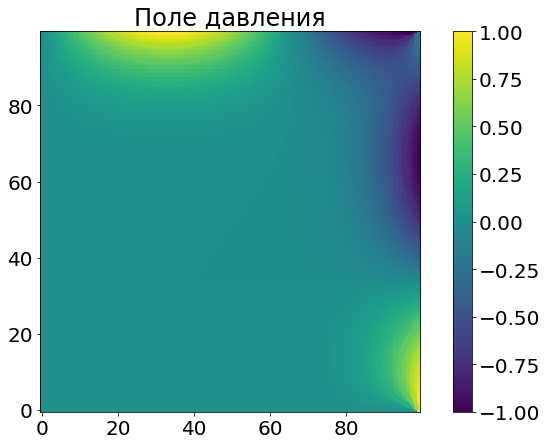

In [28]:
# проверяем корректность численного решения
plt.figure(figsize = figsizeConst)
plt.title('Поле давления')
im = plt.imshow(pVectorized, cmap = 'viridis', origin='lower')
cs = plt.contour(pVectorized)
plt.colorbar(im)
plt.show()

## Ускорение программ с помощью средств библиотеки Numba

In [31]:
import numba as nb

Простой пример:

In [41]:
def CalculateFibonacciNumber(n):
    a = 0
    b = 1
    for i in range(n):
        a, b = b, a + b
    return a


# добавляем спецификатор jit()
@nb.jit()
def CalculateFibonacciNumberJITted(n):
    a = 0
    b = 1
    for i in range(n):
        a, b = b, a + b
    return a

In [33]:
n = int(1e6)

start = timeit.default_timer()
CalculateFibonacciNumber(n)
runtimeScalar = (timeit.default_timer() - start)

print ('Вычисления заняли %.2e с.' % runtimeScalar)

Вычисления заняли 1.60e+01 с.


In [44]:
# реальное значение ускорения будет со 2-го запуска ячейки, когда функцию уже не требуется компилироват

start = timeit.default_timer()
CalculateFibonacciNumberJITted(n)
runtimeJITted = (timeit.default_timer() - start)

print ('Вычисления заняли %.2e с.' % runtimeJITted)
print ('Ускорение: %.0f.' % (runtimeScalar/runtimeJITted))

Вычисления заняли 4.86e-04 с.
Ускорение: 32855.


### Вернемся назад: подробнее об интерпретаторе  Python

Интерпретатор Python &mdash; на самом деле не один объект, а совокупность из нескольких составляющих: компилятора, виртуальной машины (PVM) и сборщика мусора. Соответственно, сначала текстовый файл __.py__ компилируется в байт-код (файл с расширением __.pyc__) для __виртуальной машины Python (PVM)__, который затем выполняется (интерпретируется):

<img src="https://adw0rd.com/media/2009/08/python.png">


### Компиляция участков кода
С помощью средств библиотеки __Numba__ возможно ускорить __отдельные участки__ байт-кода за счет их компиляции; этими участками могут быть __только функции__. Компиляция участков происходит __во время интерпретации__, поэтому за данное свойство к слову "компиляция" добавляют приставку "JIT" (от англ. "just-in-time" = "на лету"). От пользователя требуется размечать участки для ускорения в __исходном__ текстовом файле программы &mdash; разметку в соответствующие участки байт-кода автоматически "перенесет" компилятор.


Формальное определение __JIT-компиляции__: это технология увеличения производительности программных систем, использующих байт-код, путём компиляции байт-кода в машинный код или в другой формат непосредственно во время работы программы. Таким образом достигается высокая скорость выполнения по сравнению с интерпретируемым байт-кодом (сравнимая с компилируемыми языками) за счёт увеличения потребления памяти (для хранения результатов компиляции) и затрат времени на компиляцию.


__Ограничения__ для функций, к которым можно применять JIT-компиляцию:
* отсутствие использования глобальных переменных
* отсутсвие векторизованных операций Numpy (хотя в последних версиях библиотеки стали поддерживаться некоторые математические функции из Numpy)
* использование средств Numpy разрешено только при инициализации массивов
* отсутсвие операций с высокоуровневыми структурами данных стандартной бибилиотеки Python: со списками, кортежами, словарями и пр.

__Numba__ может ускорять довольно сложные функции, но все же иногда ей это не удается. В этом случае она сгенерирует функцию, ничем не отличающуюся по произодительности от изначальной __без каких-либо оповещений__. Запуск Numba в nopython-режиме заставит библиотеку выдавать ошибку в случае неудачного исхода JIT-компиляции функции &mdash; либо получаем ускоренную функцию, либо ничего:

In [45]:
@nb.jit(nopython=True)
def CalculateFibonacciNumberJITted(n):
    a = 0
    b = 1
    for i in range(n):
        a, b = b, a + b
    return a

### Работа с массивами
Добавляем спецификатор __@jit__ к функциям, в которых реализован скалярный код покоординатных операций над масиивами:

In [46]:
@nb.jit(nopython=True)
def AddArraysJIT(array1, array2):
    n = len(array1)
    resultArray = np.zeros(n)
    for i in range(n):
        resultArray[i] = array1[i] + array2[i]
    return resultArray

@nb.jit(nopython=True)
def MultiplyArraysJIT(array1, array2):
    n = len(array1)
    resultArray = np.zeros(n)
    for i in range(n):
        resultArray[i] = array1[i] * array2[i]
    return resultArray

@nb.jit(nopython=True)
def SpecificFunctionArrayJIT(array):
    n = len(array)
    resultArray = np.zeros(n)
    for i in range(n):
        resultArray[i] = m.cos(m.sin(array[i]**2.)) / (1. + m.exp(-2.*array[i]))
    return resultArray

Ускорение JIT-скомпилированных функций по сравнению со скалярными и векторизованными:

In [48]:
# реальное значение ускорения будет со 2-го запуска ячейки, когда функцию уже не требуется компилировать
# сравнение ускорений
runtimesScalarList, runtimesVectorizedList, runtimesJittedList = [], [], []
lengthsList = [int(1.5**i) for i in range(2, 10)]

for length in lengthsList:
    arrayA = np.array([5*i for i in range(int(length))])
    arrayB = arrayA.copy()
    
    
    timingScalar = %timeit -o SpecificFunctionArray(arrayB)
    timingVectorized = %timeit -o SpecificFunctionArrayVectorized(arrayB)
    timingJITted = %timeit -o SpecificFunctionArrayJIT(arrayB)
    
    runtimesScalarList.append(timingScalar.best)
    runtimesVectorizedList.append(timingVectorized.best)
    runtimesJittedList.append(timingJITted.best)

    
    
runtimesScalarList = np.array(runtimesScalarList) 
runtimesVectorizedList = np.array(runtimesVectorizedList)
runtimesJittedList = np.array(runtimesJittedList)

20.1 µs ± 924 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11 µs ± 422 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.17 µs ± 3.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
27.1 µs ± 365 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
10.7 µs ± 42.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.3 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
44.8 µs ± 243 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.4 µs ± 465 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.42 µs ± 75.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
62.5 µs ± 573 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.2 µs ± 56.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.49 µs ± 4.06 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
103 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
11.7 µs ± 286 ns per loop (mean ± std

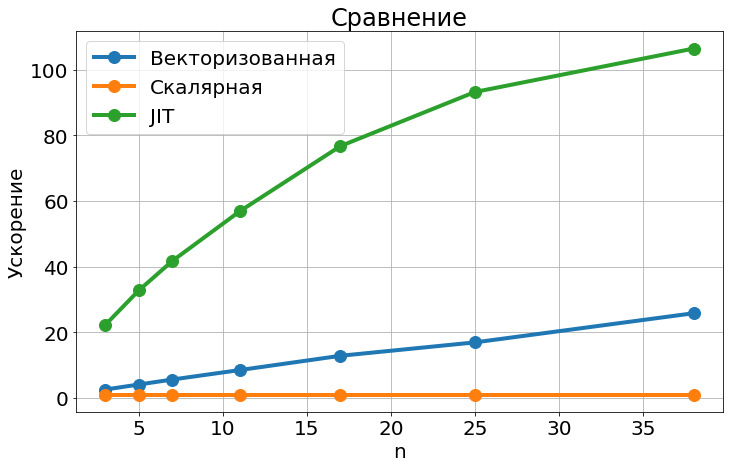

In [49]:
plt.figure(figsize=figsizeConst)
plt.title('Сравнение')
plt.plot(lengthsList[1:], runtimesScalarList[1:]/runtimesVectorizedList[1:], label='Векторизованная')
plt.plot(lengthsList[1:], runtimesScalarList[1:]/runtimesScalarList[1:], label='Скалярная')
plt.plot(lengthsList[1:], runtimesScalarList[1:]/runtimesJittedList[1:], label='JIT')
plt.ylabel('Ускорение')
plt.xlabel('n')
plt.legend(loc='best')
plt.grid('off')
plt.show()

### Однородное линейное уравнение теплопроводности

Шаг #10000
Шаг #20000
Шаг #30000
Шаг #40000
Шаг #50000
Шаг #60000
Шаг #70000
Шаг #80000
Вычисления заняли 1.26e+00 с


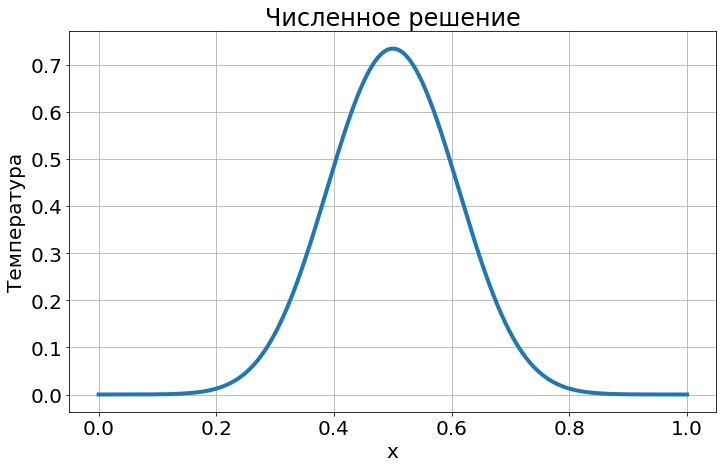

In [55]:
# реальное значение ускорения будет со 2-го запуска ячейки, когда функцию уже не требуется компилировать

xLeft = 0.
xRight = 1.
kappa = 0.1
t = 0.
tRun = 0.04

def InitialCondition(x):
    if x < 0.6 and x > 0.4:
        return 1.
    else:
        return 0.


def SetInitialCondition(function, array, numPoints, h):
    for i in range(numPoints):
        array[i] = function(i * h)

def MakeStepScalar(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h)
    for i in range(1, numPoints - 1):
        uNew[i] = uOld[i] + courant * (uOld[i + 1] - 2 * uOld[i] + uOld[i - 1])
    
def MakeStepVectorized(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h) 
    uNew[1:numPoints-1] = uOld[1:numPoints-1] + courant*(uOld[2:numPoints] - 2*uOld[1:numPoints-1] \
                                                        + uOld[:numPoints-2])
    
@nb.jit(nopython=True)
def MakeStepJITted(uOld, numPoints, h, dt, kappa, uNew):
    courant = kappa * dt / (h * h)
    for i in range(1, numPoints - 1):
        uNew[i] = uOld[i] + courant * (uOld[i + 1] - 2 * uOld[i] + uOld[i - 1])


# main
counter = 0
counterBlocks = 0

numBlocks = int(1e3)
import time

start = timeit.default_timer()
numPoints = int(numBlocks + 1)
uOld, uNew = np.zeros(numPoints), np.zeros(numPoints)
h = float(xRight - xLeft) / float(numBlocks)
dt = h**2 / (kappa * 20.)
SetInitialCondition(InitialCondition, uOld, numPoints, h)
    
while t < tRun:
    
    #MakeStepScalar(uOld, numPoints, h, dt, kappa, uNew)
    MakeStepVectorized(uOld, numPoints, h, dt, kappa, uNew)
    #MakeStepJITted(uOld, numPoints, h, dt, kappa, uNew)
    
    uOld = uNew
    t += dt; counter += 1
    if (counter % int(1e4)) == 0:
        print ('Шаг #%d' % counter)

end = timeit.default_timer()
runtime = (end - start)
print ('Вычисления заняли %.2e с' % runtime)

    
xArray = np.linspace(xLeft, xRight, numPoints)
plt.figure(figsize=figsizeConst)
plt.title('Численное решение')
plt.plot(xArray, uNew, '-', linewidth=4)
plt.xlabel('x')
plt.ylabel('Температура')
plt.grid('off')
plt.show()

### Метод Якоби

In [56]:
# реальное значение ускорения будет со 2-го запуска ячейки, когда функцию уже не требуется компилировать

@nb.jit(nopython=True)
def SolveLaplace2D_JacobiJITted(p, numBlocksX, numBlocksY, tolerance):
    
    normL2 = 1.
    pn = np.zeros((numBlocksY, numBlocksX))
    iterations = 0
    
    #start = time.clock() # функции замера времени --- нельзя использовать
    while normL2 > tolerance:
        for i in range(numBlocksX):
            for j in range(numBlocksY):
                pn[i, j] = p[i, j]
        
        for i in range(1, numBlocksX - 1):
            for j in range(1, numBlocksY - 1):
                p[i, j] = 0.25 * (pn[i, j + 1] + pn[i, j - 1] +\
                                      pn[i + 1, j] + pn[i - 1, j])
        
        numerator, denumenator = 0., 0.
        for i in range(numBlocksX):
            for j in range(numBlocksY): 
                numerator += (p[i, j] - pn[i, j])**2
                denumenator += pn[i, j]**2
            
        normL2 = np.sqrt(numerator/denumenator)
        iterations += 1
    
    #runtime = time.clock() - start # функции замера времени --- нельзя использовать
    #print('%d iterations completed.' % (iterations)) # функции вывода на экран --- нельзя использовать
    return p, iterations

In [59]:
tolerance = 1e-3

pScalar, runtimeScalar = SolveLaplace2D_JacobiScalar(p0.copy(), numBlocksX, numBlocksY, tolerance)
pVectorized, runtimeVectorized = SolveLaplace2D_JacobiVectorized(p0.copy(), numBlocksX, numBlocksY, tolerance)

start = timeit.default_timer()
pJITted, iterationsJITted = SolveLaplace2D_JacobiJITted(p0.copy(), numBlocksX, numBlocksY, tolerance)
runtimeJITted = timeit.default_timer() - start
print ('%d итераций завершены в JIT-солвере метода Якоби; вычисления заняли %.2f с.' % (iterationsJITted, runtimeJITted))


print ('Ускорение: JIT = %.0f; векторизованная = %.0f;' % ((runtimeScalar/runtimeJITted),\
                                                      (runtimeScalar/runtimeVectorized)))

313 итераций завершены в процессе работы скалярной реализации метода Якоби; вычисления заняли 13.78 с
313 итераций завершены в процессе работы векторизованной реализации метода Якоби; вычисления заняли 0.05 с
313 итераций завершены в JIT-солвере метода Якоби; вычисления заняли 0.01 с.
Ускорение: JIT = 1772; векторизованная = 261;


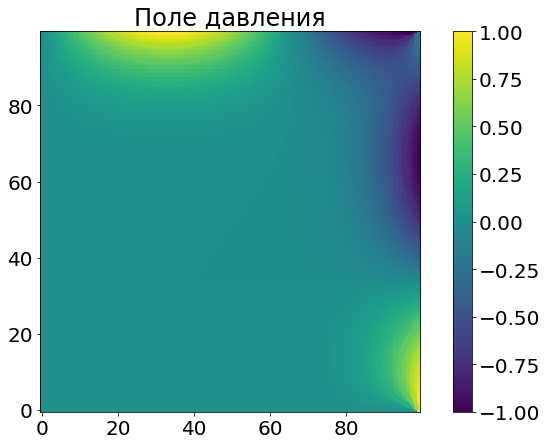

In [60]:
# проверяем корректность численного решения
plt.figure(figsize = figsizeConst)
plt.title('Поле давления')
im = plt.imshow(pJITted, cmap = 'viridis', origin='lower')
cs = plt.contour(pJITted)
plt.colorbar(im)
plt.show()

### Поддержка классов: "work in progress" (с) Сontinuum Analytics

In [65]:
real = nb.float32 # псевдоним для типа данных Numba

# список имен полей и их тип
spec = [
    ('x', real),      
    ('y', real), 
    ('length', real),
]


@nb.jitclass(spec)
class Vector:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def CalculateLength(self):
        self.length = np.sqrt(self.x**2 + self.y**2)
        return self.length

In [63]:
vector1 = Vector(5., 10.)
vector1.CalculateLength()

11.180339813232422

__НА ЗАМЕТКУ:__ конечно, сложности взаимодействия JIT-компилятора с классами Python ограничивают применение первого для ускорения работы программных комплексов, написанных  в объектно-ориентированной парадигме. Однако, если в написанной Вами с помощью процедурной парадигмы программе число строк кода не будет превышать ~1000 (с учетом будущей поддержки и расширения функциональности), то JIT-компиляцию можно свободно использовать. В любом случае всегда имеется вариант задействования только библиотеки Numpy.

### Принципы ускорения программ с помощью Numba
* выделить самые ресурсоемкие участки кода (обычно это циклы по точкам расчетной сетки)
* "обернуть" эти участки в функции
* внутри функций ликвидировать операции со сложными структурами данных, использование глобальных переменных
* задействовать JIT-компиляцию: добавить к функциям спецификатор @jit(nopython=True)

Также: с помощью Numba можно писать программы для __GP-GPU:__

In [ ]:
# чтобы код в этой ячейка стал рабочим требуется корректная установка библиотек для работы с Nvidia GPU
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

Справка по библиотеке Numba: http://numba.pydata.org, http://numba.pydata.org/numba-doc/latest/user/jit.html

## Вопросы?

## При подготовке материалов курса использовалась следующая литература:
1. *Langtangen H. P.* A primer on scientific programming with Python
2. *Шамин Р. В.* Современные численные методы в объектно-ориентированном изложении на C#.

# Спасибо за внимание в течение семестра.